In [7]:
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as sla
from mpl_toolkits.mplot3d import Axes3D
fig_size = (10,10)

In [8]:
A_wiener = np.array([[0., 1.],[0., 0.]])
B_wiener = np.array([[0.],[1.]])
process_noise_variance = 0.1
measurement_noise_variance = 1.
dt = 0.01

F_wiener = np.array([[1., dt],[0., 1.]])
Q_wiener_discrete = process_noise_variance * np.array([[(dt**3)/3, (dt**2)/2],[(dt**2)/2,dt]])
x_wiener_init = np.array([0.,1.])
t_wiener = np.arange(1001)*dt

R = measurement_noise_variance*np.eye(1)
q = np.random.multivariate_normal(np.zeros(2),Q_wiener_discrete,(t_wiener.shape[0]))
r = np.random.multivariate_normal(np.zeros(1),R,t_wiener.shape[0])

In [9]:
def propagate_linear_discrete_system_with_noise(F,x_init,length, v):
    x = np.zeros((length,x_init.shape[0]))
    x[0] = x_init
    for i in range(length-1):
        x[i+1] = F@x[i]+v[i]
    return x

In [10]:
H_wiener = np.array([[1., 0.]])

In [11]:
x_wiener = propagate_linear_discrete_system_with_noise(F_wiener,x_wiener_init,t_wiener.shape[0],q)

In [12]:
y_wiener = x_wiener@H_wiener.T + r

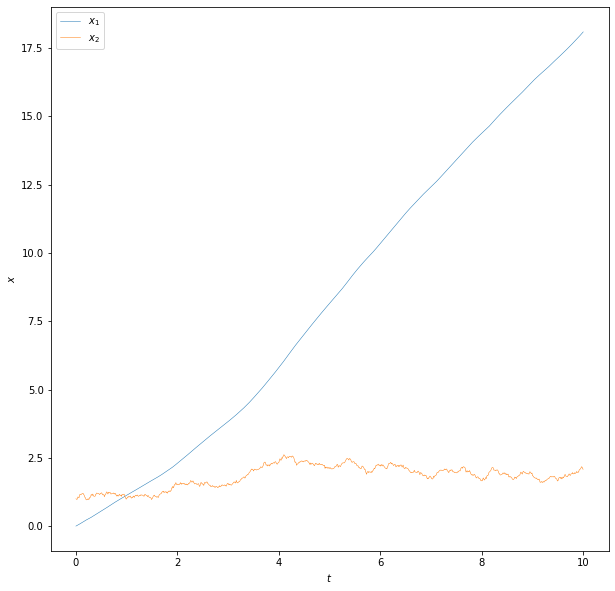

In [13]:
plt.figure(figsize=fig_size)
plt.plot(t_wiener,x_wiener[:,0],linewidth=0.5, label='$x_1$')
plt.plot(t_wiener,x_wiener[:,1],linewidth=0.5, label='$x_2$')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend()

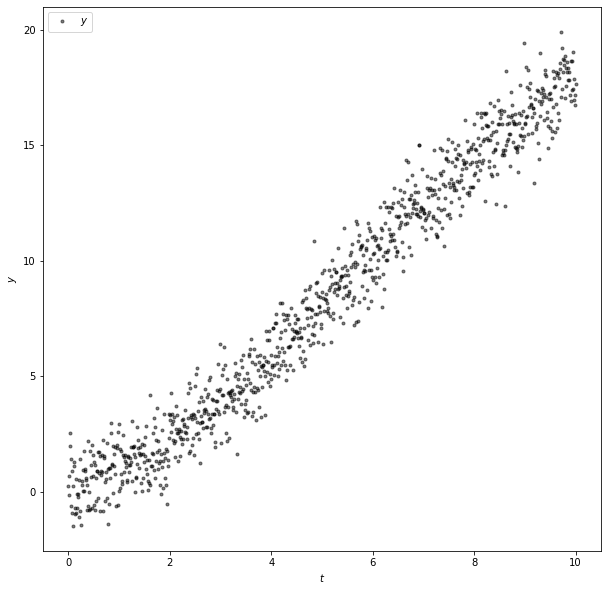

In [14]:
plt.figure(figsize=fig_size)
plt.plot(t_wiener,y_wiener,'ok',markersize=3,alpha=0.5, label='$y$')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend()

In [15]:
def Kalman_filter(F,H,x_init,cov_init,Q_discrete,R_discrete,y):
    length = y.shape[0]
    x = np.zeros((length,x_init.shape[0]))
    P = np.zeros((length,x_init.shape[0],x_init.shape[0]))
    x[0] = x_init
    P[0] = cov_init
    for i in range(length-1):
        x_     = F@x[i]
        P_     = F@P[i]@F.T + Q_discrete
        
        S      = H@P_@H.T + R_discrete
        K_tran = sla.solve(S,H@P_)
        P[i+1] = P_ - K_tran.T@S@K_tran
        x[i+1] = x_ + K_tran.T@(y[i]-H@x_)
    return x, P

In [16]:
cov_init = 0.01*np.eye(2)
x_kalman,cov_kalman = Kalman_filter(F_wiener,H_wiener,x_wiener_init,cov_init,Q_wiener_discrete,R,y_wiener)

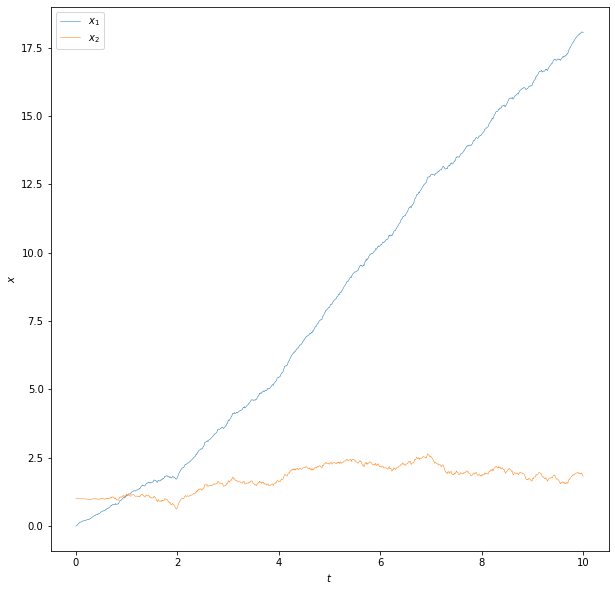

In [17]:
plt.figure(figsize=fig_size)
plt.plot(t_wiener,x_kalman[:,0],linewidth=0.5, label='$x_1$')
plt.plot(t_wiener,x_kalman[:,1],linewidth=0.5, label='$x_2$')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend()

In [18]:
RMSE_raw = np.sum(np.square(y_wiener.flatten()-x_wiener[:,0]))/y_wiener.shape[0]
RMSE_kalman = np.sum(np.square(x_kalman[:,0]-x_wiener[:,0]))/y_wiener.shape[0]
print('RMSE of raw measurement = {}, and RMSE of Kalman filter = {}'.format(RMSE_raw,RMSE_kalman))

RMSE of raw measurement = 0.9870393656849786, and RMSE of Kalman filter = 0.028469029708703585


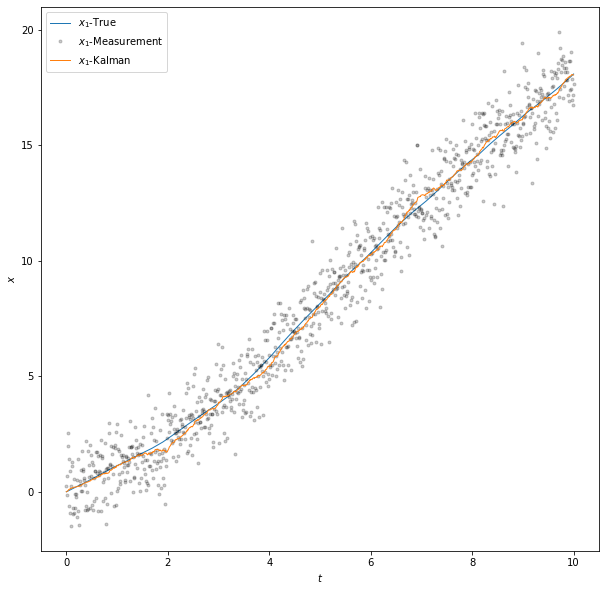

In [19]:
plt.figure(figsize=fig_size)
plt.plot(t_wiener,x_wiener[:,0],linewidth=1, label='$x_1$-True')
plt.plot(t_wiener,y_wiener,'ok',markersize=3,label='$x_1$-Measurement',alpha=0.2)
plt.plot(t_wiener,x_kalman[:,0],linewidth=1, label='$x_1$-Kalman')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend()

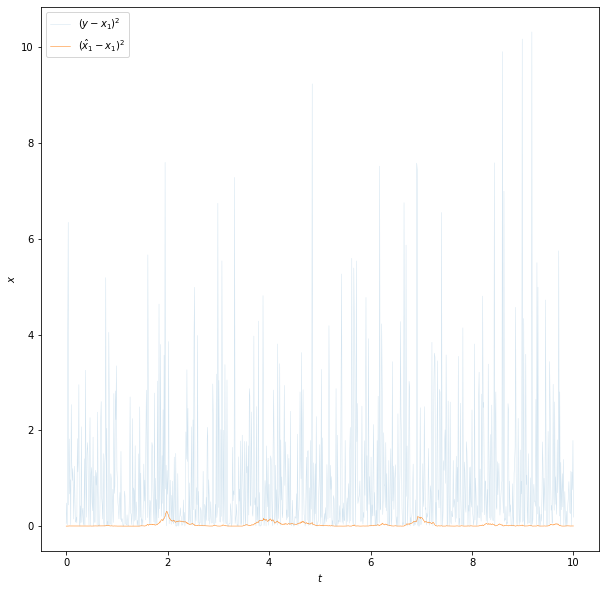

In [20]:
plt.figure(figsize=fig_size)
plt.plot(t_wiener,np.square(x_wiener[:,0]-y_wiener.flatten()),linewidth=0.5,alpha=0.2, label='$(y - x_1)^2$')
plt.plot(t_wiener,np.square(x_wiener[:,0]-x_kalman[:,0]),linewidth=0.5, label='$(\hat{x}_1 - x_1)^2$')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend()

# Question 2 (Sequential least squares and Kalman filter)


In [21]:
## Initialization
x_drone = np.array([0.5,0.5,0.5])#true position
L_drone = 1.
I_3 = np.eye(3)
H_drone = np.vstack((I_3,-I_3))
b_drone = np.array([0.,0.,0.,L_drone,L_drone,L_drone])

n_sensors = 6
stdev_drone = 5e-2 #equal for all sensors
r_drone  = stdev_drone*np.random.randn(n_sensors)
R_drone = stdev_drone*stdev_drone*np.eye(n_sensors)
y_drone = H_drone@x_drone+b_drone+r_drone

#pick an m and P
m_drone = np.array([0.,0.,0.]) #put initially
P_drone = 1e-2*I_3# If you put P small, you better make sure that (x-m) is very close
P_drone = (P_drone+P_drone.T)/2
R_drone_inv = np.linalg.inv(R_drone)
P_drone_inv = np.linalg.inv(P_drone)

##Batch solution
y_tilde = y_drone - b_drone
x_WLS = np.linalg.solve(H_drone.T@R_drone_inv@H_drone, H_drone.T@R_drone_inv@y_tilde)
x_reg_WLS = np.linalg.solve(H_drone.T@R_drone_inv@H_drone+P_drone_inv, H_drone.T@R_drone_inv@y_tilde+P_drone_inv@m_drone)
P_reg_WLS_inv = H_drone.T@R_drone_inv@H_drone+P_drone_inv
P_WLS_inv = H_drone.T@R_drone_inv@H_drone

In [22]:
x_drone_history = np.zeros((n_sensors+1,3))
P_drone_history = np.zeros((n_sensors+1,3,3))
x_drone_est = m_drone
x_drone_history[0,:] = x_drone_est
P_drone_est = P_drone
P_drone_history[0] = P_drone_est
for i in range(n_sensors):
    #There is no apriori update here why?
    H_i = H_drone[i,:]
    s = (np.inner(H_i,P_drone_est@H_i)+R_drone[i,i])
    K = P_drone_est@H_i/s #explain why
    x_drone_est = x_drone_est + K*(y_tilde[i] - H_i@x_drone_est)
    P_drone_est = P_drone_est - np.outer(K,K)*s
    x_drone_history[i+1] = x_drone_est
    P_drone_history[i+1] = P_drone_est

In [23]:
print(x_reg_WLS)
print(x_WLS)
print(x_drone_history)

[0.47957096 0.44021416 0.36137556]
[0.53951733 0.49524093 0.4065475 ]
[[0.         0.         0.        ]
 [0.40872448 0.         0.        ]
 [0.40872448 0.38570449 0.        ]
 [0.40872448 0.38570449 0.34381356]
 [0.47957096 0.38570449 0.34381356]
 [0.47957096 0.44021416 0.34381356]
 [0.47957096 0.44021416 0.36137556]]


In [24]:
#Get x,y,z that will draw an ellipse with center in x_c and matrix P as its ellipse parameter
def get_ellipse(ellipse_center,ellipse_P, num_points=100):
    U, s, rotation = sla.svd(ellipse_P)
    radii = 1.0/np.sqrt(s)
    # now carry on with EOL's answer
    u = np.linspace(0.0, 2.0 * np.pi, num_points)
    v = np.linspace(0.0, np.pi, num_points)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + ellipse_center
    
    return x,y,z

In [25]:
#Draw some ellipse
el_rwls_x,el_rwls_y,el_rwls_z = get_ellipse(x_reg_WLS,P_reg_WLS_inv)
el_wls_x,el_wls_y,el_wls_z = get_ellipse(x_WLS,P_WLS_inv)

(0.0, 1.0)

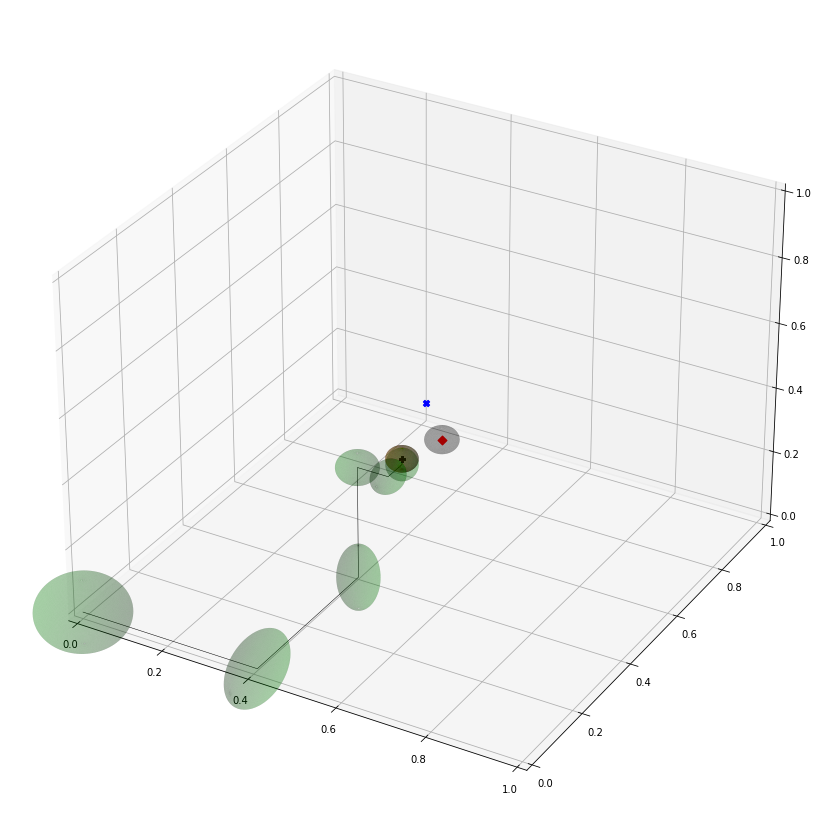

In [26]:
fig = plt.figure(figsize=(15,15))
point_size=40
ax = fig.add_subplot(111, projection='3d')
x_True = np.array([x_drone[0]])
y_True = np.array([x_drone[1]])
z_True = np.array([x_drone[2]])


ax.scatter(x_drone[0],x_drone[1],x_drone[2],c='b',s=point_size,marker="X")
ax.scatter(x_WLS[0],x_WLS[1],x_WLS[2],c='r',s=point_size,marker="D")
ax.scatter(x_reg_WLS[0],x_reg_WLS[1],x_reg_WLS[2],c='k',s=point_size,marker="P")

ax.plot_surface(el_rwls_x,el_rwls_y,el_rwls_z,  rstride=1, cstride=1, color='r', alpha=0.2, linewidth=0)
ax.plot_surface(el_wls_x,el_wls_y,el_wls_z,  rstride=1, cstride=1, color='k', alpha=0.2, linewidth=0)
ax.plot(x_drone_history[:,0],x_drone_history[:,1],x_drone_history[:,2],c='k',linewidth=0.5)
for i in range(x_drone_history.shape[0]):
    x_ellipse_drone,y_ellipse_drone,z_ellipse_drone = get_ellipse(x_drone_history[i,:],np.linalg.inv(P_drone_history[i]))
    ax.plot_surface(x_ellipse_drone,y_ellipse_drone,z_ellipse_drone,  rstride=1, cstride=1, color='g', alpha=0.2, linewidth=0)
    
ax.set_xlim(0,1.)
ax.set_ylim(0,1.)
ax.set_zlim(0,1.)

In [27]:
process_noise_variance_3d = 0.1
measurement_noise_variance_3d = 1.
dt_3d = 0.01
F_wiener_1d = np.array([[1., dt_3d],[0., 1.]])
F_wiener_3d = sla.block_diag(F_wiener_1d,F_wiener_1d,F_wiener_1d)
Q_wiener_discrete_1d = process_noise_variance_3d * np.array([[(dt_3d**3)/3, (dt_3d**2)/2],[(dt_3d**2)/2,dt_3d]])
Q_wiener_discrete_3d = sla.block_diag(Q_wiener_discrete_1d,Q_wiener_discrete_1d,Q_wiener_discrete_1d)
x_wiener_init_3d = np.array([0.,1.,0.,1.,0.,1.])
t_wiener_3d = np.arange(1001)*dt_3d
R_3d = measurement_noise_variance_3d*np.eye(6)
R_3d_inv = np.linalg.inv(R_3d)
q_3d = np.random.multivariate_normal(np.zeros(6),Q_wiener_discrete_3d,(t_wiener_3d.shape[0]))
r_3d = np.random.multivariate_normal(np.zeros(6),R_3d,t_wiener_3d.shape[0])
H_wiener_3d = np.array([[1., 0., 0., 0., 0., 0.],
                     [0., 0., 1., 0., 0., 0.],
                     [0., 0., 0., 0., 1., 0.],
                     [-1., 0., 0., 0., 0., 0.],
                     [0., 0., -1., 0., 0., 0.],
                     [0., 0., 0., 0., -1., 0.]
                    ])


In [28]:
x_wiener_3d = propagate_linear_discrete_system_with_noise(F_wiener_3d,x_wiener_init_3d,t_wiener_3d.shape[0],q_3d)
y_wiener_3d = x_wiener_3d@H_wiener_3d.T + r_3d + b_drone

In [29]:
P_drone = 10*I_3# If you put P small, you better make sure that (x-m) is very close
P_drone = (P_drone+P_drone.T)/2
P_drone_inv = np.linalg.inv(P_drone)
x_reg_WLS_3d = np.empty((y_wiener_3d.shape[0]+1,3))
x_reg_WLS_3d[0] = x_wiener_init_3d[[0,2,4]]
for i in range(y_wiener_3d.shape[0]):
    x_reg_WLS_3d[i+1] = np.linalg.solve(H_drone.T@R_3d_inv@H_drone+P_drone_inv, H_drone.T@R_3d_inv@(y_wiener_3d[i]-b_drone)
                                        +P_drone_inv@x_reg_WLS_3d[i])

In [30]:
cov_init_3d = 0.01*np.eye(6)
x_kalman_3d,cov_kalman_3d = Kalman_filter(F_wiener_3d,H_wiener_3d,x_wiener_init_3d,cov_init_3d,Q_wiener_discrete_3d,R_3d,y_wiener_3d-b_drone)
kalman_output_3d = x_kalman_3d@H_wiener_3d.T

In [31]:
 H_drone.T@R_3d_inv

array([[ 1.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  1.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  1.,  0.,  0., -1.]])

In [32]:
row_idx = np.array([0,2,4])
col_idx = np.array([0,2,4])
cov_kalman_3d[-1,row_idx[:,None],col_idx]

array([[0.01473209, 0.        , 0.        ],
       [0.        , 0.01473209, 0.        ],
       [0.        , 0.        , 0.01473209]])

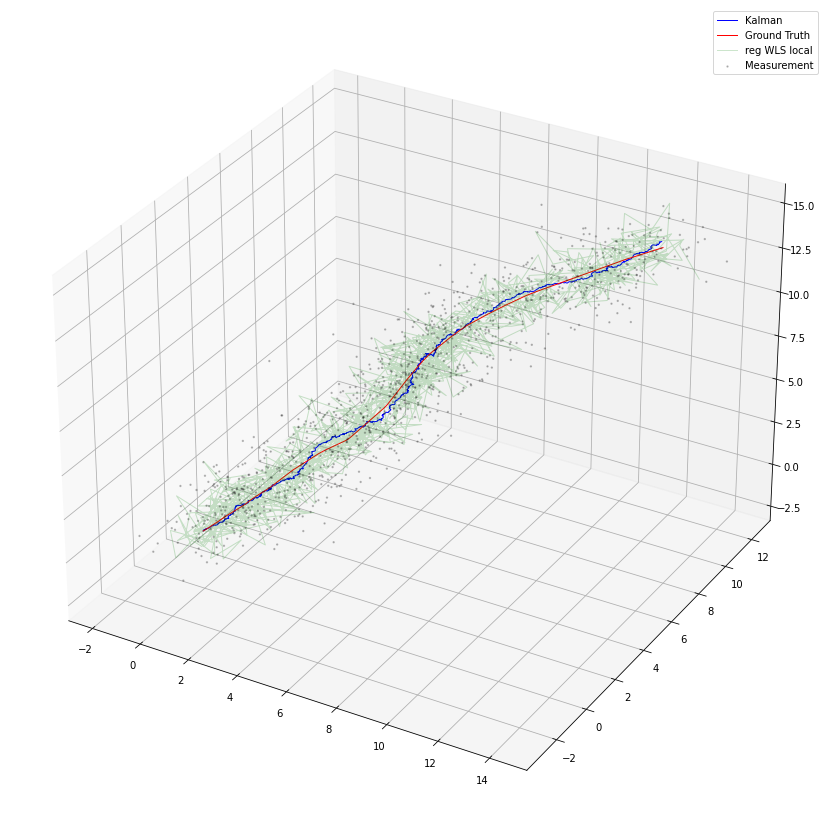

In [33]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot(kalman_output_3d[:,0],kalman_output_3d[:,1],kalman_output_3d[:,2], c='b', linewidth=1,label='Kalman')
ax.plot(x_wiener_3d[:,0],x_wiener_3d[:,2],x_wiener_3d[:,4], c='r', linewidth=1,label='Ground Truth')
ax.plot(x_reg_WLS_3d[:,0],x_reg_WLS_3d[:,1],x_reg_WLS_3d[:,2], c='g', linewidth=1,label='reg WLS local', alpha=0.2)
ax.scatter(y_wiener_3d[:,0],y_wiener_3d[:,1],y_wiener_3d[:,2],s=2, c='k', alpha=0.2,label='Measurement')
ax.set_x_label=('$x$')
ax.set_y_label=('$y$')
ax.set_z_label=('$z$')
ax.legend()
